#### Инициализация

In [11]:
'''Импорт библиотек'''
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
import cv2
#pip install opencv-python
import numpy as np
from lmfit.models import GaussianModel
gauss = GaussianModel()

'''Подавление предупреждений срабатывания lmfit.GaussModel.guess() -- она создаёт UFloat'''
import warnings
warnings.filterwarnings("ignore", message="Using UFloat objects with std_dev==0")

'''Частота излучения и сечение поглощения'''
frequency = 709078373.01 * 10 ** 6 # [Hz]
c = 299792458 # [m/s]
wavelength = (c/frequency) * 10 ** 2 # [cm]
crosssection = (3 * wavelength ** 2 ) / (2 * np.pi) # [cm^2]

'''Калибровка'''# [cm/px]
Kx_abs = 0.001102980962138891

#### Обработка поглощения

In [2]:
file_abs = "image_2"
directory = r"../2025-05-27_densityInvolute/b=115/"

'''Чтение и разбиение файла'''
img = PIL.Image.open(directory + file_abs + ".tif") #initially a grayscale image

shots = []
try:
    while True:
        frame = np.array(img)
        shots.append(frame)
        img.seek(img.tell() + 1) #go to next frame
except EOFError: #end of frames case
    pass

I_atoms = shots[0] #I
I_lbeam = shots[1] #I0

'''Определение количества пикселей по осям i и j'''
rows, columns = I_atoms.shape

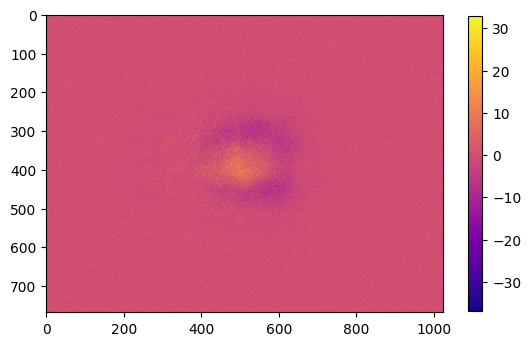

In [3]:
'''Приведение к uint8 и замена нулей, чтобы не возникало ошибок при делении матриц'''
I_atoms = cv2.normalize(I_atoms, None, 1, 256, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
I_lbeam = cv2.normalize(I_lbeam, None, 1, 256, cv2.NORM_MINMAX, dtype=cv2.CV_16U)

'''Определение пропускания T(x,y)'''
T = (I_atoms/I_lbeam).astype(np.float32)

'''Визуализация'''
D = I_lbeam.astype(np.int16)-I_atoms.astype(np.int16)
plt.imshow(D, cmap="plasma")
plt.colorbar(shrink=.8)

#### Поиск центра облака

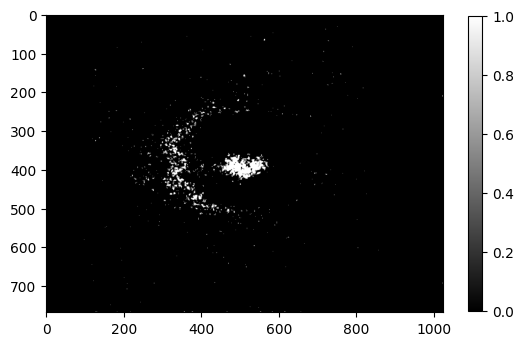

In [4]:
'''Фильтрация физичных T<=1'''
F = np.copy(T)
for i in range(rows): #rows
    for j in range(columns): #columns
        if T[i, j] > 1:
            F[i, j] = 1

'''Медианное сглаживание шумов'''
M = cv2.medianBlur(F, 5)

'''Фильтрация пропускания меньше порогового значения'''
TRSH = 0.96 #пороговое значение
_, binary = cv2.threshold(M, TRSH, 1, cv2.THRESH_BINARY_INV)
# THRESH_BINARY_INV:
#  ≤ TRSH = белые
#  > TRSH = черные

'''Визуализация'''
plt.imshow(binary, cmap="gray")
plt.colorbar(shrink=.8)

In [5]:
'''Выделение контура поглощения'''
binary_uint8 = np.uint8(binary * 255) #требуется для cv2.findContours()
contours, _ = cv2.findContours(binary_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
assert contours != (), "Err: no contours found"
    
largest_contour = max(contours, key=cv2.contourArea)

ROI = np.zeros_like(T, dtype=np.uint8)
cv2.drawContours(ROI, [largest_contour], -1, 255, thickness=cv2.FILLED)

'''Нахождение минимума пропускания в нём'''
min_val, _, (jc_abs, ic_abs), _ = cv2.minMaxLoc(T, mask=ROI)
print(f"Критическое пропускание\tTc: {min_val}\nКритическая точка\tC: {(ic_abs, jc_abs)} ")

Критическое пропускание	Tc: 0.760869562625885
Критическая точка	C: (406, 511) 


In [6]:
'''Отрисовка полученного контура'''
output = cv2.cvtColor(T, cv2.COLOR_GRAY2BGR)  # Переводим в цветное для рисования
cv2.drawContours(output, [largest_contour], -1, (.9, 0, .8), 2)
cv2.circle(output, (jc_abs, ic_abs), 6, (0, 0, 1), -1)
cv2.imshow("", output)
cv2.waitKey(0)

235

In [7]:
cv2.destroyAllWindows()

#### Обработка центральной горизонтали

fwhm: 129.580 px
deviation: 55.028 px
peak absorption: 5.205%


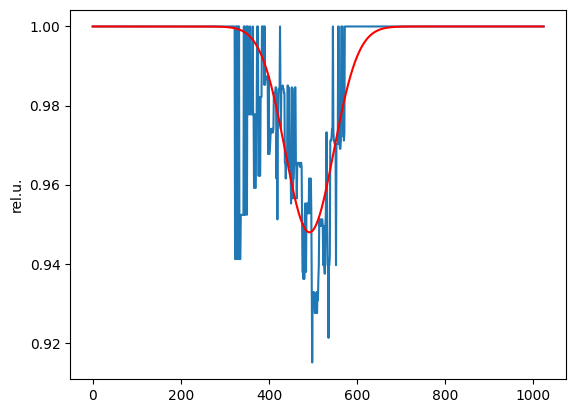

In [8]:
'''Профиль по оси j (для величины w_x)'''
data = 1-M[ic_abs, :]
arg = np.arange(0, columns, 1)
plt.plot(arg, 1-data)

#Фитирование нормальным распределением
model = GaussianModel()
pars = gauss.guess(data, x=arg) #затравочные параметры
out = gauss.fit(data, pars, x=arg, calc_covar=False)
#print(out.fit_report())

fwhm_abs = out.params["fwhm"].value
w_abs = out.params["sigma"].value
Abs = max(out.best_fit)

print("fwhm: %.3f px" % fwhm_abs)
print("deviation: %.3f px" % w_abs)
print("peak absorption: %.3f%%" % (Abs*100))

plt.ylabel("rel.u.")
plt.plot(arg, 1-out.best_fit, "r-")
plt.show()

#### Расчёт концентрации

In [9]:
'''Расчет пиковой концентрации.'''
n0 = -np.log(T[ic_abs, jc_abs])/(np.sqrt(2*np.pi)*w_abs*Kx_abs*crosssection)
print("n0: %.2e cm^-3" % n0)

n0: 2.10e+09 cm^-3


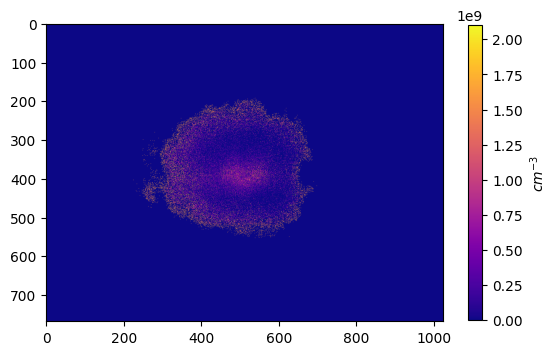

In [10]:
'''Профиль концентрации атомов n(x, y)'''
n = -np.log(T)/(np.sqrt(2*np.pi)*w_abs*Kx_abs*crosssection).astype(np.float32)

'''Фильтрация физичных плотностей'''
for i in range(rows): #rows
    for j in range(columns): #columns
        if n[i, j] < 0.:
            n[i, j] = 0.
        elif n[i, j] > n0:
            n[i, j] = 0.

'''Визуализация'''
plt.imshow(n, cmap="plasma")
plt.colorbar(shrink=.8, label="$cm^{-3}$")